## Mean Reversion & VWAP

#### 均值回歸檢定測試：平穩態、ADF Test

In [131]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = yf.download('BTC-USD', start='2020-01-01', end='2022-08-31')

[*********************100%%**********************]  1 of 1 completed


In [132]:
# 計算價格的日回報率
df['Return'] = df['Close'].pct_change().dropna()


# 進行 ADF 檢定
adf_result = adfuller(df['Return'].dropna())

# 獲取 ADF 統計量
adf_statistic = adf_result[0]
adf_p_value = adf_result[1]

print(f"ADF 統計量 (tau): {adf_statistic}")
print(f"P 值: {adf_p_value}")

ADF 統計量 (tau): -9.97668348674092
P 值: 2.168274966424929e-17


In [99]:
df['Return'] = df['Close'].pct_change().dropna()

In [100]:
from statsmodels.tsa.stattools import adfuller

# 進行 ADF 檢定
adf_result = adfuller(df['Return'].dropna())

# 獲取 ADF 統計量、P 值和其他信息
adf_statistic = adf_result[0]
p_value = adf_result[1]
lags_used = adf_result[2]
n_obs = adf_result[3]
critical_values = adf_result[4]

print(f"ADF 統計量 (tau): {adf_statistic}")
print(f"P 值: {p_value}")
print(f"使用的滯後階數 (p): {lags_used}")
print(f"臨界值: {critical_values}")

ADF 統計量 (tau): -9.97668348674092
P 值: 2.168274966424929e-17
使用的滯後階數 (p): 8
臨界值: {'1%': -3.4371587399783072, '5%': -2.8645459603872903, '10%': -2.568370536787406}


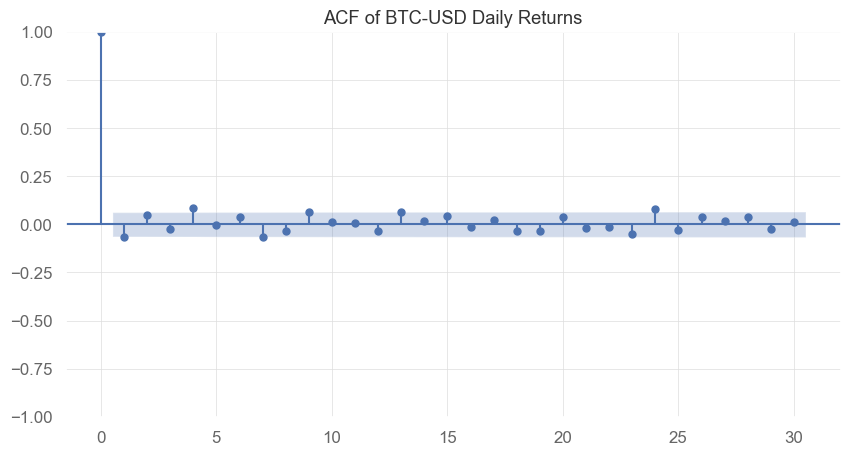

/Users/lawrencechang/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


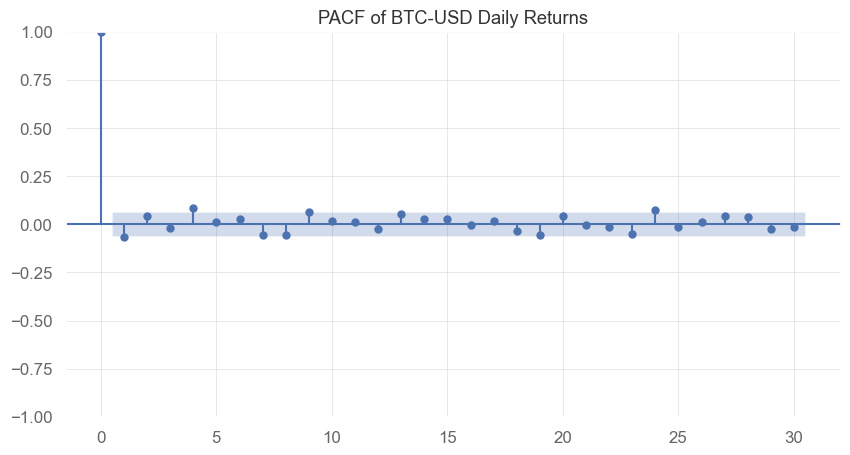

In [101]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 繪製回報率的自相關函數（ACF）圖
plt.figure(figsize=(10,5))
plot_acf(df['Return'].dropna(), lags=30, ax=plt.gca())
plt.title('ACF of BTC-USD Daily Returns')
plt.show()

# 繪製回報率的偏自相關函數（PACF）圖
plt.figure(figsize=(10, 5))
plot_pacf(df['Return'].dropna(), lags=30, ax=plt.gca())
plt.title('PACF of BTC-USD Daily Returns')
plt.show()

#### 套入VWAP參數最作為交易濾網，策略夠為穩健，樣本內優化

In [75]:
import seaborn as sns

##### 定義函數

In [133]:
# Define the mean reversion strategy with V
def mean_reversion_with_vwap(df, ema_period, threshold, vwap_period):
    if ema_period < 1:
        return -np.inf  # Return a very low value if ema_period is invalid
    
    # Calculate EMA
    df['EMA'] = df['Close'].ewm(span=ema_period).mean()
    
    # Calculate VWAP
    df['VWAP'] = (df['Close'] * df['Volume']).rolling(window=vwap_period).sum() / df['Volume'].rolling(window=vwap_period).sum()
    
    # Calculate the difference between Close, EMA, and VWAP
    df['distance_EMA'] = df['Close'] - df['EMA']
    df['distance_VWAP'] = df['Close'] - df['VWAP']
    
    # Generate position signals using both EMA and VWAP
    df['position'] = np.where((df['distance_EMA'] < threshold) & (df['distance_VWAP'] > threshold), -1, np.nan)
    df['position'] = np.where((df['distance_EMA'] > -threshold) & (df['distance_VWAP'] < threshold), 1, df['position'])
    df['position'] = np.where(df['distance_EMA'] * df['distance_EMA'].shift(1) < 0, 0, df['position'])
    df['position'] = df['position'].ffill().fillna(0)
    
    # Calculate strategy returns
    df['strategy_return'] = df['position'].shift(1) * df['Close'].pct_change()
    df['cumulative_return'] = (df['strategy_return'] + 1).cumprod() - 1
    
    return df['cumulative_return'].iloc[-1]

[*********************100%%**********************]  1 of 1 completed


[]

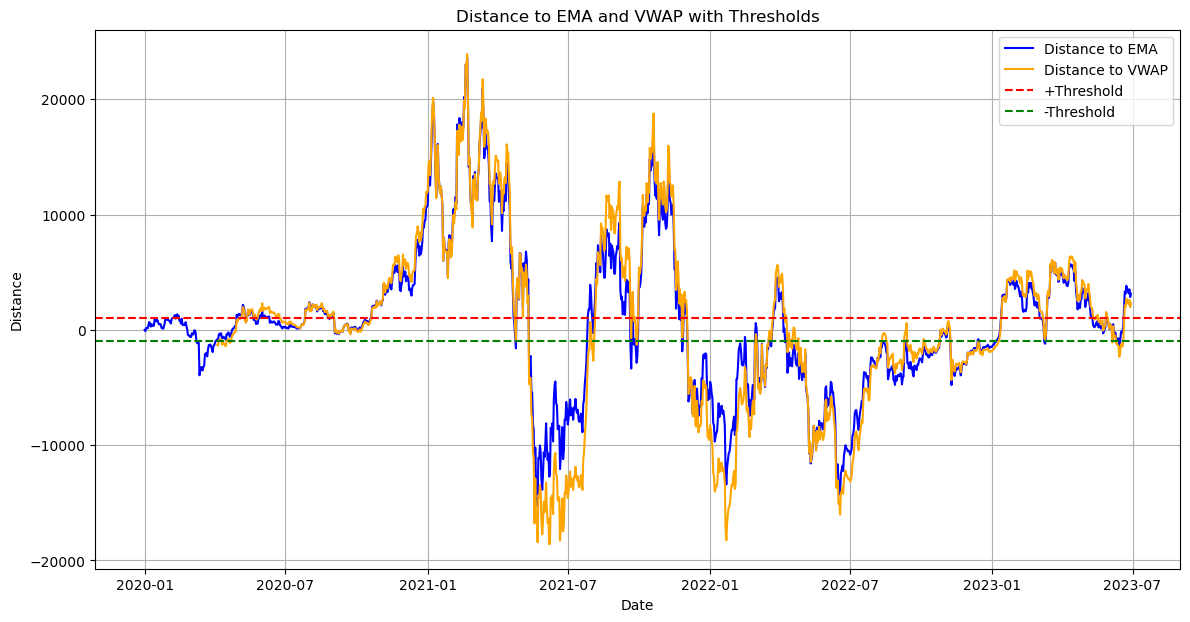

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# 下載比特幣歷史數據
df = yf.download('BTC-USD', start='2020-01-01', end='2023-06-30')

# 設置參數
ema_period = 90
vwap_period = 95
threshold = 1000

# 計算 EMA
df['EMA'] = df['Close'].ewm(span=ema_period).mean()

# 計算 VWAP
df['VWAP'] = (df['Close'] * df['Volume']).rolling(window=vwap_period).sum() / df['Volume'].rolling(window=vwap_period).sum()

# 計算價格與 EMA 和 VWAP 的差異
df['distance_EMA'] = df['Close'] - df['EMA']
df['distance_VWAP'] = df['Close'] - df['VWAP']

# 繪圖
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['distance_EMA'], label='Distance to EMA', color='blue')
plt.plot(df.index, df['distance_VWAP'], label='Distance to VWAP', color='orange')
plt.axhline(y=threshold, color='red', linestyle='--', label='+Threshold')
plt.axhline(y=-threshold, color='green', linestyle='--', label='-Threshold')

plt.title('Distance to EMA and VWAP with Thresholds')
plt.xlabel('Date')
plt.ylabel('Distance')
plt.legend()
plt.grid(True)
plt.plot()

##### Grid Search

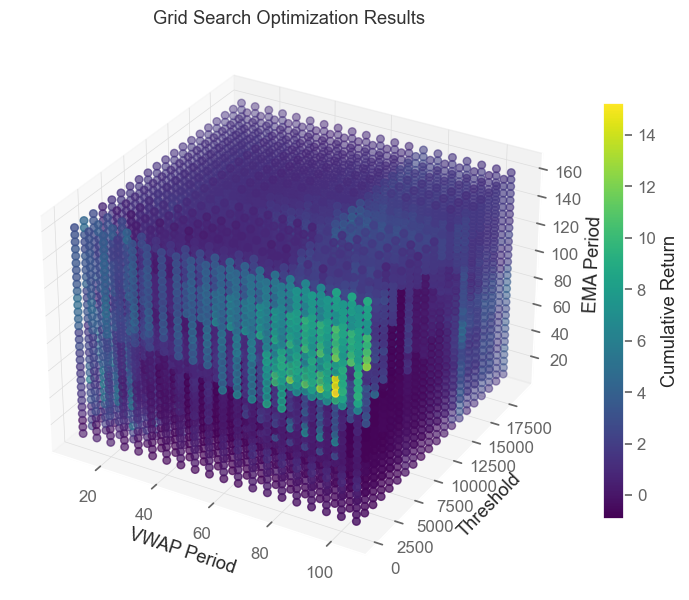

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

ema_range = np.arange(10, 161, 5)  
threshold_range = np.arange(0, 20000, 1000)
vwap_range = np.arange(10, 106, 5)


results = []

for vwap in vwap_range:
    for ema in ema_range:
        for threshold in threshold_range:
            ret = mean_reversion_with_vwap(df.copy(), ema, threshold, vwap)
            results.append((vwap, ema, threshold, ret))

results_df = pd.DataFrame(results, columns=['VWAP', 'EMA', 'Threshold', 'Cumulative Return'])

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

x = results_df['VWAP']
y = results_df['Threshold']
z = results_df['EMA']
c = results_df['Cumulative Return']  

img = ax.scatter(x, y, z, c=c, cmap='viridis', marker='o', s=30)  

cbar = plt.colorbar(img, ax=ax, shrink = 0.6)
cbar.set_label('Cumulative Return')

ax.set_xlabel('VWAP Period')
ax.set_ylabel('Threshold')
ax.set_zlabel('EMA Period')
ax.set_title('Grid Search Optimization Results')

plt.show()

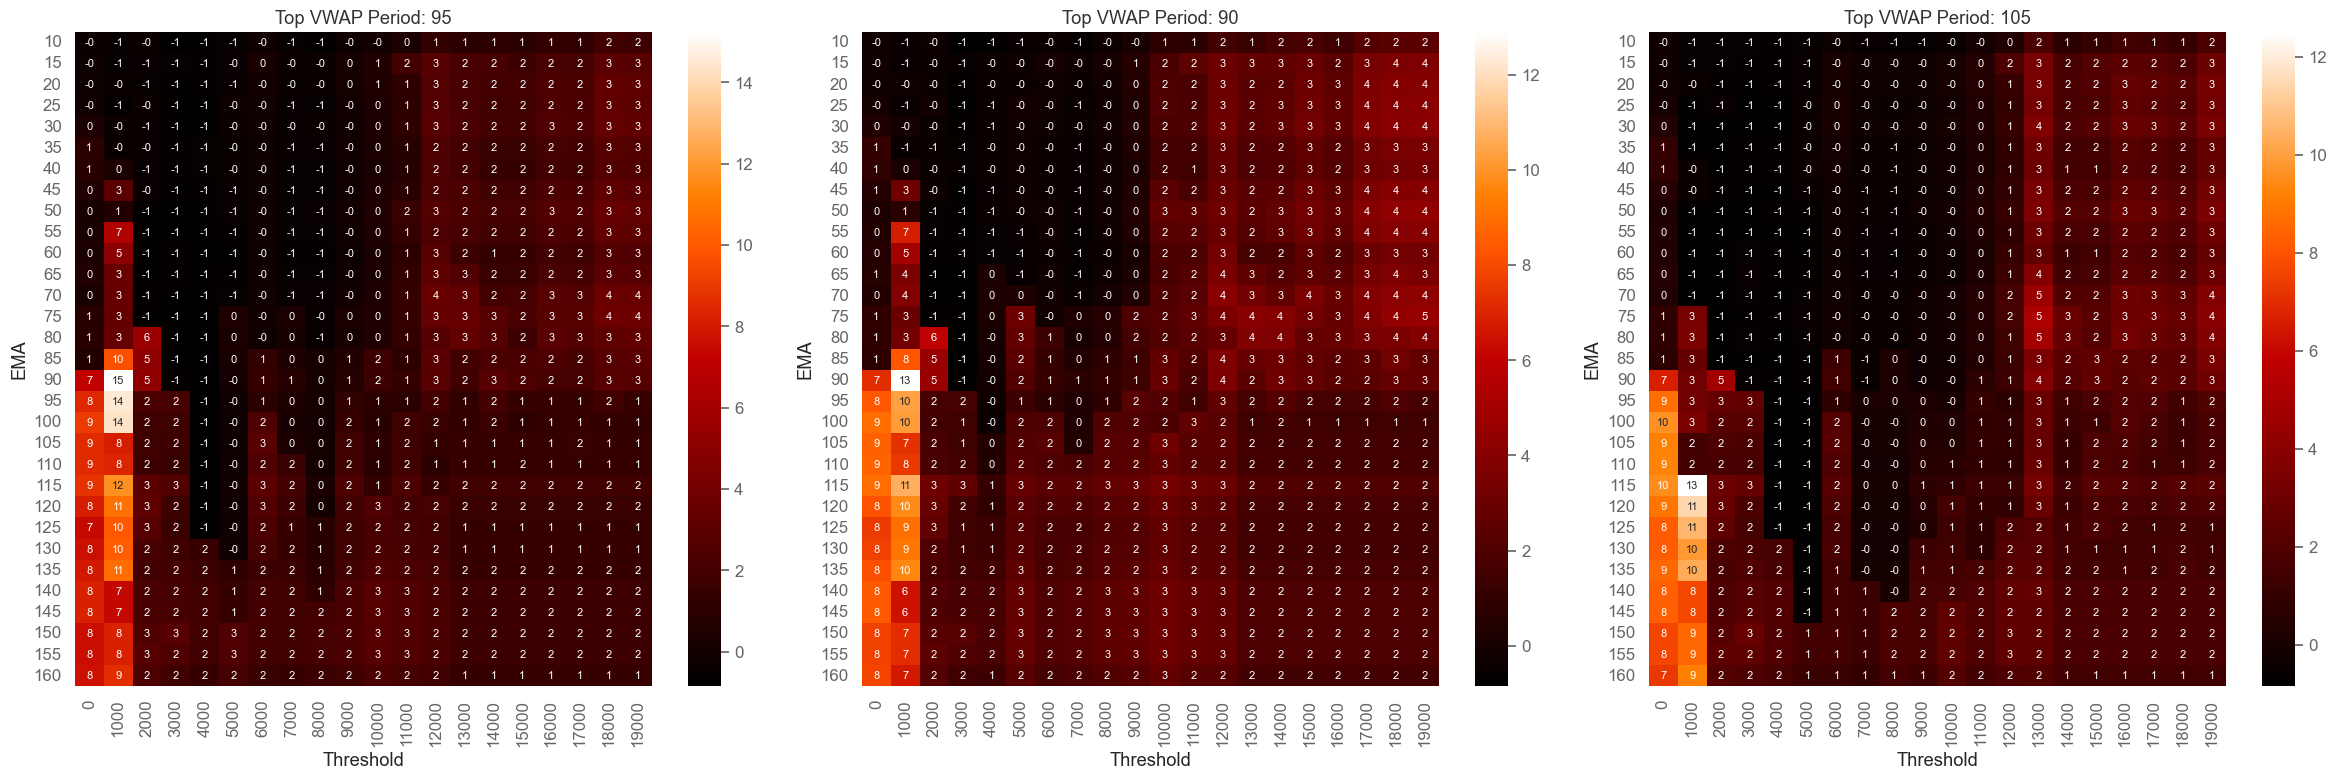

In [76]:

# Define the mean reversion strategy with V
def mean_reversion_with_vwap(df, ema_period, threshold, vwap_period):
    if ema_period < 1:
        return -np.inf  # Return a very low value if ema_period is invalid
    
    # Calculate EMA
    df['EMA'] = df['Close'].ewm(span=ema_period).mean()
    
    # Calculate VWAP
    df['VWAP'] = (df['Close'] * df['Volume']).rolling(window=vwap_period).sum() / df['Volume'].rolling(window=vwap_period).sum()
    
    # Calculate the difference between Close, EMA, and VWAP
    df['distance_EMA'] = df['Close'] - df['EMA']
    df['distance_VWAP'] = df['Close'] - df['VWAP']
    
    # Generate position signals using both EMA and VWAP
    df['position'] = np.where((df['distance_EMA'] < threshold) & (df['distance_VWAP'] > threshold), -1, np.nan)
    df['position'] = np.where((df['distance_EMA'] > -threshold) & (df['distance_VWAP'] < threshold), 1, df['position'])
    df['position'] = np.where(df['distance_EMA'] * df['distance_EMA'].shift(1) < 0, 0, df['position'])
    df['position'] = df['position'].ffill().fillna(0)
    
    # Calculate strategy returns
    df['strategy_return'] = df['position'].shift(1) * df['Close'].pct_change()
    df['cumulative_return'] = (df['strategy_return'] + 1).cumprod() - 1
    
    return df['cumulative_return'].iloc[-1]

# Define parameter grids
ema_range = np.arange(10, 161, 5)
threshold_range = np.arange(0, 20000, 1000)
vwap_range = np.arange(10, 106, 5)

# Calculate cumulative returns for all VWAP periods
vwap_results = {}
for vwap in vwap_range:
    results = {}
    for ema in ema_range:
        for threshold in threshold_range:
            ret = mean_reversion_with_vwap(df, ema, threshold, vwap)
            results[(ema, threshold)] = ret
    
    # Calculate the maximum cumulative return for this VWAP period
    max_return = max(results.values())
    vwap_results[vwap] = max_return

# Identify the top 3 VWAP periods with the highest maximum cumulative returns
top_3_vwaps = sorted(vwap_results, key=vwap_results.get, reverse=True)[:3]

# Plot heatmaps for the top 3 VWAP periods
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

for i, vwap in enumerate(top_3_vwaps):
    results = {}
    for ema in ema_range:
        for threshold in threshold_range:
            ret = mean_reversion_with_vwap(df, ema, threshold, vwap)
            results[(ema, threshold)] = ret
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(
        [(ema, threshold, ret) for (ema, threshold), ret in results.items()],
        columns=['EMA', 'Threshold', 'Return']
    )
    
    # Pivot the data for heatmap visualization
    pivot_table = results_df.pivot_table(index='EMA', columns='Threshold', values='Return', aggfunc='mean')
    
    # Plot heatmap with annotations
    sns.heatmap(pivot_table, annot=True, fmt=".0f", ax=axes[i],  annot_kws={"size": 8}, cmap='gist_heat', cbar=True)
    axes[i].set_title(f'Top VWAP Period: {vwap}')
    axes[i].set_xlabel('Threshold')
    axes[i].set_ylabel('EMA')

plt.tight_layout()
plt.show()

#### 參數優化後的組合策略配置

In [115]:
# Define the mean reversion strategy with VWAP and calculate net returns after fee
def mean_reversion_with_fees(df, ema_period, threshold, vwap_period, fee=0.0004):
    if ema_period < 1:
        return -np.inf  # Return a very low value if ema_period is invalid
    
    # Calculate EMA
    df['EMA'] = df['Close'].ewm(span=ema_period).mean()
    
    # Calculate VWAP
    df['VWAP'] = (df['Close'] * df['Volume']).rolling(window=vwap_period).sum() / df['Volume'].rolling(window=vwap_period).sum()
    
    # Calculate the difference between Close, EMA, and VWAP
    df['distance_EMA'] = df['Close'] - df['EMA']
    df['distance_VWAP'] = df['Close'] - df['VWAP']
    
    # Generate position signals using both EMA and VWAP
    df['position'] = np.where((df['distance_EMA'] < threshold) & (df['distance_VWAP'] > threshold), -1, np.nan)
    df['position'] = np.where((df['distance_EMA'] > -threshold) & (df['distance_VWAP'] < threshold), 1, df['position'])
    df['position'] = np.where(df['distance_EMA'] * df['distance_EMA'].shift(1) < 0, 0, df['position'])
    df['position'] = df['position'].ffill().fillna(0)
    
    # Calculate strategy returns
    df['strategy_return'] = df['position'].shift(1) * df['Close'].pct_change()
    
    # Calculate transaction costs (fee applies each time a position changes)
    df['trade'] = df['position'].diff().abs()  # A trade occurs when the position changes
    trade_count = df['trade'].sum()  # Total number of trades
    df['fee_cost'] = df['trade'] * fee  # Fee cost for each trade
    total_fee = df['fee_cost'].sum()  # Total transaction cost
    
    # Calculate cumulative returns after fees
    df['net_return'] = df['strategy_return'] - df['fee_cost']
    cumulative_return = (df['net_return'] + 1).cumprod().iloc[-1] - 1
    
    # Calculate annualized return after fees
    trading_days = df['net_return'].count()
    annualized_return = (1 + cumulative_return) ** (365 / trading_days) - 1
    
    # Calculate annualized volatility
    volatility = df['net_return'].std() * np.sqrt(365)
    
    return cumulative_return, trade_count, total_fee, annualized_return, volatility

# Define the strategies
strategies = [
    (95, 90, 1000),
    (90, 90, 1000),
    (105, 115, 1000)
]

# Calculate returns, trade counts, fees, and volatilities for each strategy
results = []
for vwap, ema, threshold in strategies:
    cum_return, trade_count, total_fee, ann_return, vol = mean_reversion_with_fees(df.copy(), ema, threshold, vwap)
    results.append((vwap, ema, threshold, cum_return, trade_count, total_fee, ann_return, vol))

# Convert to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=[
    'VWAP', 'EMA', 'Threshold', 'Cumulative Return', 'Trade Count', 
    'Total Fee', 'Annualized Return', 'Volatility'
])
results_df['Sharpe Ratio'] = results_df['Annualized Return'] / results_df['Volatility']


results_df

,VWAP,EMA,Threshold,Cumulative Return,Trade Count,Total Fee,Annualized Return,Volatility,Sharpe Ratio
0,95,90,1000,14.902891,53.0,0.0212,1.825996,0.543586,3.359168
1,90,90,1000,12.603694,53.0,0.0212,1.665045,0.533121,3.123204
2,105,115,1000,12.298710,39.0,0.0156,1.642449,0.547441,3.000231


#### 等權重優化

In [13]:
# Given data
data = {
    'VWAP': [95, 90, 105],
    'EMA': [90, 90, 115],
    'Threshold': [1000, 1000, 1000],
    'Cumulative Return': [14.902891, 12.603694, 12.298710],
    'Trade Count': [53.0, 53.0, 39.0],
    'Total Fee': [0.0212, 0.0212, 0.0156],
    'Annualized Return': [1.825996, 1.665045, 1.642449],
    'Volatility': [0.543586, 0.533121, 0.547441],
    'Sharpe Ratio': [3.359168, 3.123204, 3.000231]
}

# Convert to DataFrame
results_df = pd.DataFrame(data)

# Calculate the equal-weighted cumulative return
equal_weighted_cumulative_return = sum(results_df['Cumulative Return']) / 3

# Calculate the equal-weighted annualized return
equal_weighted_annualized_return = sum(results_df['Annualized Return']) / 3

# Calculate the equal-weighted volatility (assuming independent strategies)
equal_weighted_volatility = (sum(results_df['Volatility']**2) / 3)**0.5

# Calculate the equal-weighted Sharpe Ratio
equal_weighted_sharpe_ratio = equal_weighted_annualized_return / equal_weighted_volatility

# Calculate the correct trade count and total fee as averages
equal_weighted_trade_count = results_df['Trade Count'].sum()
equal_weighted_total_fee = results_df['Total Fee'].sum()

# Create the equal-weighted row
equal_weighted_results = {
    'VWAP': 'Equal-Weighted',
    'EMA': 'Equal-Weighted',
    'Threshold': 'Equal-Weighted',
    'Cumulative Return': equal_weighted_cumulative_return,
    'Trade Count': equal_weighted_trade_count,
    'Total Fee': equal_weighted_total_fee,
    'Annualized Return': equal_weighted_annualized_return,
    'Volatility': equal_weighted_volatility,
    'Sharpe Ratio': equal_weighted_sharpe_ratio
}

# Add the equal-weighted results to the DataFrame
equal_weighted_results_df = pd.DataFrame([equal_weighted_results])
results_df = pd.concat([results_df, equal_weighted_results_df], ignore_index=True)

results_df

,VWAP,EMA,Threshold,Cumulative Return,Trade Count,Total Fee,Annualized Return,Volatility,Sharpe Ratio
0,95,90,1000,14.902891,53.0,0.0212,1.825996,0.543586,3.359168
1,90,90,1000,12.603694,53.0,0.0212,1.665045,0.533121,3.123204
2,105,115,1000,12.298710,39.0,0.0156,1.642449,0.547441,3.000231
3,Equal-Weighted,Equal-Weighted,Equal-Weighted,13.268432,145.0,0.0580,1.711163,0.541416,3.160531


In [29]:

df = yf.download('BTC-USD', start='2020-01-01', end='2023-06-30')
def mean_reversion_with_fees(df, ema_period, threshold, vwap_period, fee=0.0004):
    df['EMA'] = df['Close'].ewm(span=ema_period).mean()
    df['VWAP'] = (df['Close'] * df['Volume']).rolling(window=vwap_period).sum() / df['Volume'].rolling(window=vwap_period).sum()
    
    df['distance_EMA'] = df['Close'] - df['EMA']
    df['distance_VWAP'] = df['Close'] - df['VWAP']
    
    df['position'] = np.where((df['distance_EMA'] < threshold) & (df['distance_VWAP'] > threshold), -1, np.nan)
    df['position'] = np.where((df['distance_EMA'] > -threshold) & (df['distance_VWAP'] < threshold), 1, df['position'])
    df['position'] = np.where(df['distance_EMA'] * df['distance_EMA'].shift(1) < 0, 0, df['position'])
    df['position'] = df['position'].ffill().fillna(0)
    
    df['strategy_return'] = df['position'].shift(1) * df['Close'].pct_change()
    df['trade'] = df['position'].diff().abs()
    
    df['net_return'] = df['strategy_return'] - df['trade'] * fee
    return df['net_return']

strategies = [
    (95, 90, 1000),
    (90, 90, 1000),
    (105, 115, 1000)
]

time_periods = [
    ('2020-01-01', '2022-08-31'),
    ('2022-09-01', '2023-06-30'),
    ('2020-01-01', '2023-06-30')
]

results = []

for start_date, end_date in time_periods:
    strategy_returns = pd.Series(0, index=df[(df.index >= start_date) & (df.index <= end_date)].index)
    
    for vwap, ema, threshold in strategies:
        sub_df = df[(df.index >= start_date) & (df.index <= end_date)].copy()
        returns = mean_reversion_with_fees(sub_df, ema, threshold, vwap)
        strategy_returns = strategy_returns.add(returns, fill_value=0)
    
    
    strategy_returns /= len(strategies)
    
    cumulative_return = (strategy_returns + 1).prod() - 1
    annualized_return = (1 + cumulative_return) ** (365 / len(strategy_returns)) - 1
    annualized_volatility = strategy_returns.std() * np.sqrt(365)
    sharpe_ratio = annualized_return / annualized_volatility
    
    
    results.append({
        'Period': f"{start_date} to {end_date}",
        'Cumulative Return': cumulative_return,
        'Annualized Return': annualized_return,
        'Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio
    })

results_df = pd.DataFrame(results)
print(results_df)

[*********************100%%**********************]  1 of 1 completed

                     Period  Cumulative Return  Annualized Return  Volatility  \
0  2020-01-01 to 2022-08-31          13.559424           1.728227    0.515314   
1  2022-09-01 to 2023-06-30           0.405832           0.509363    0.279786   
2  2020-01-01 to 2023-06-30          15.047526           1.212112    0.472734   

   Sharpe Ratio  
0      3.353733  
1      1.820545  
2      2.564048  


In [30]:
results_1 = {'Strategy': '等權重',
    'Cumulative Return': '13.559424',
    'Annualized Return': '1.728227'	,
    'Sharpe Ratio': '3.353733'	,
    'Trade Count': '145.0',
    'Total Fee': '0.0580',
    'Volatility': '0.515314'}

results_df = pd.DataFrame([results_1])
results_df

,Strategy,Cumulative Return,Annualized Return,Sharpe Ratio,Trade Count,Total Fee,Volatility
0,等權重,13.559424,1.728227,3.353733,145.0,0.0580,0.515314


#### 交易次數計算

In [19]:

df = yf.download('BTC-USD', start='2020-01-01', end='2023-06-30')

def mean_reversion_with_fees(df, ema_period, threshold, vwap_period, fee=0.0004):
    if ema_period < 1:
        return -np.inf
    
    df['EMA'] = df['Close'].ewm(span=ema_period).mean()
    df['VWAP'] = (df['Close'] * df['Volume']).rolling(window=vwap_period).sum() / df['Volume'].rolling(window=vwap_period).sum()
    
    df['distance_EMA'] = df['Close'] - df['EMA']
    df['distance_VWAP'] = df['Close'] - df['VWAP']
    
    df['position'] = np.where((df['distance_EMA'] < threshold) & (df['distance_VWAP'] > threshold), -1, np.nan)
    df['position'] = np.where((df['distance_EMA'] > -threshold) & (df['distance_VWAP'] < threshold), 1, df['position'])
    df['position'] = np.where(df['distance_EMA'] * df['distance_EMA'].shift(1) < 0, 0, df['position'])
    df['position'] = df['position'].ffill().fillna(0)
    
    df['strategy_return'] = df['position'].shift(1) * df['Close'].pct_change()
    df['trade'] = df['position'].diff().abs()
    
    return df['trade'].sum()

strategies = [
    (95, 90, 1000),
    (90, 90, 1000),
    (105, 115, 1000)
]

time_periods = [
    ('2020-01-01', '2022-08-31'),
    ('2022-09-01', '2023-06-30'),
    ('2020-01-01', '2023-06-30')
]

equal_weighted_trades = []
for start_date, end_date in time_periods:
    total_trades = 0
    for vwap, ema, threshold in strategies:
        sub_df = df[(df.index >= start_date) & (df.index <= end_date)].copy()
        trades = mean_reversion_with_fees(sub_df, ema, threshold, vwap)
        total_trades += trades
    equal_weighted_trades.append(total_trades)

for period, trades in zip(time_periods, equal_weighted_trades):
    print(f"Period {period[0]} to {period[1]}: Total Trades = {trades}")

[*********************100%%**********************]  1 of 1 completed

Period 2020-01-01 to 2022-08-31: Total Trades = 145.0
Period 2022-09-01 to 2023-06-30: Total Trades = 73.0
Period 2020-01-01 to 2023-06-30: Total Trades = 227.0


#### 信號同步比較

In [3]:
df = yf.download('BTC-USD', start='2020-01-01', end='2022-08-31')

# Define the mean reversion strategy with VWAP and calculate net returns after fe
def generate_signals(df, ema_period, threshold, vwap_period):
    df['EMA'] = df['Close'].ewm(span=ema_period).mean()
    df['VWAP'] = (df['Close'] * df['Volume']).rolling(window=vwap_period).sum() / df['Volume'].rolling(window=vwap_period).sum()
    df['distance_EMA'] = df['Close'] - df['EMA']
    df['distance_VWAP'] = df['Close'] - df['VWAP']
    
    # Generate position signals
    df['position'] = np.nan
    df['position'] = np.where((df['distance_EMA'] < threshold) & (df['distance_VWAP'] > threshold), -1, df['position'])
    df['position'] = np.where((df['distance_EMA'] > -threshold) & (df['distance_VWAP'] < threshold), 1, df['position'])
    df['position'] = np.where(df['distance_EMA'] * df['distance_EMA'].shift(1) < 0, 0, df['position'])
    df['position'] = df['position'].ffill().fillna(0)
    
    return df['position']

# Define the strategies
strategies = [
    (95, 90, 1000),
    (90, 90, 1000),
    (105, 115, 1000)
]

# Generate synchronized signals
signals = pd.DataFrame(index=df.index)
for i, (vwap, ema, threshold) in enumerate(strategies):
    signals[f'Strategy_{i+1}'] = generate_signals(df.copy(), ema, threshold, vwap)

# Synchronize signals: Only trade when all strategies agree
signals['Combined_Signal'] = signals.apply(lambda row: row.min() if row.min() == row.max() else 0, axis=1)

# Calculate strategy returns based on synchronized signals
df['position'] = signals['Combined_Signal']
df['strategy_return'] = df['position'].shift(1) * df['Close'].pct_change()
df['trade'] = df['position'].diff().abs()
trade_count = df['trade'].sum()
fee = 0.0004  # Fee per trade
df['fee_cost'] = df['trade'] * fee
total_fee = df['fee_cost'].sum()

# Calculate cumulative returns, annualized return, and volatility
df['net_return'] = df['strategy_return'] - df['fee_cost']
cumulative_return = (df['net_return'] + 1).cumprod().iloc[-1] - 1
trading_days = df['net_return'].count()
annualized_return = (1 + cumulative_return) ** (365 / trading_days) - 1
volatility = df['net_return'].std() * np.sqrt(365)
sharpe_ratio = annualized_return / volatility

# Display results
results = {
    'Cumulative Return': cumulative_return,
    'Annualized Return': annualized_return,
    'Sharpe Ratio': sharpe_ratio,
    'Trade Count': trade_count,
    'Total Fee': total_fee,
    'Volatility': volatility
}

results_df = pd.DataFrame([results])
results_df

results_1 = {'Strategy': '信號同步',
    'Cumulative Return': '12.219811',
    'Annualized Return': '1.636551'	,
    'Sharpe Ratio': '3.354086'	,
    'Trade Count': '39.0',
    'Total Fee': '0.0156',
    'Volatility': '0.487928'}

results_df = pd.DataFrame([results_1])
results_df

[*********************100%%**********************]  1 of 1 completed


,Strategy,Cumulative Return,Annualized Return,Sharpe Ratio,Trade Count,Total Fee,Volatility
0,信號同步,12.219811,1.636551,3.354086,39.0,0.0156,0.487928


#### Quantstats套件回測

In [85]:
import quantstats as qs

[*********************100%%**********************]  1 of 1 completed


Backtest report for period: 2020-01-01 to 2022-08-31


[*********************100%%**********************]  1 of 1 completed


/Users/lawrencechang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/lawrencechang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/lawrencechang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pa

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-04-02   2020-04-02
End Period                 2022-08-31   2022-08-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       78.0%

Cumulative Return          203.47%      1,355.94%
CAGR﹪                     37.37%       115.13%

Sharpe                     0.84         1.93
Prob. Sharpe Ratio         94.1%        99.99%
Smart Sharpe               0.82         1.88
Sortino                    1.24         3.29
Smart Sortino              1.21         3.21
Sortino/√2                 0.87         2.33
Smart Sortino/√2           0.85         2.27
Omega                      1.51         1.51

Max Drawdown               -71.85%      -25.98%
Longest DD Days            296          389
Volatility (ann.)          58.38%       44.97%
R^2                        0.12         0.12
Information Ratio          0.04         0.04
Calmar          

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-06-19,2022-08-13,2022-08-31,74,-25.984545,-25.920036
2,2021-01-09,2021-01-27,2021-02-07,30,-25.406054,-24.442388
3,2021-04-14,2022-02-21,2022-05-07,389,-25.185746,-23.792475
4,2021-02-22,2021-02-28,2021-03-10,17,-21.554028,-19.728020
5,2021-03-14,2021-03-25,2021-04-12,30,-15.575515,-13.828206


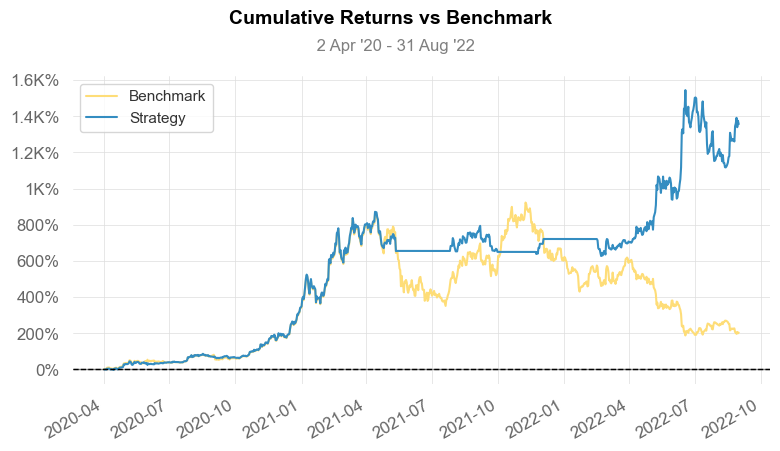

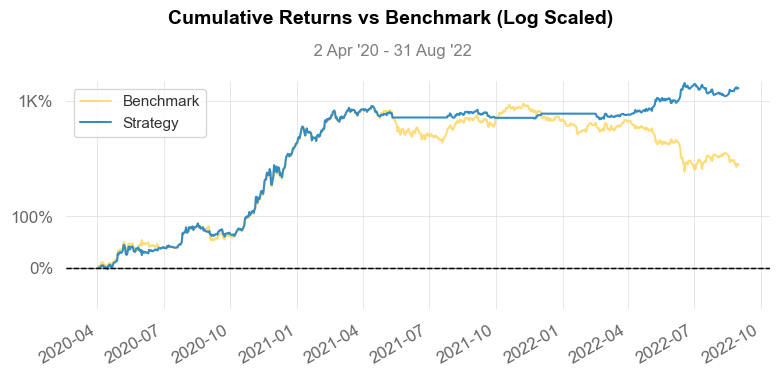

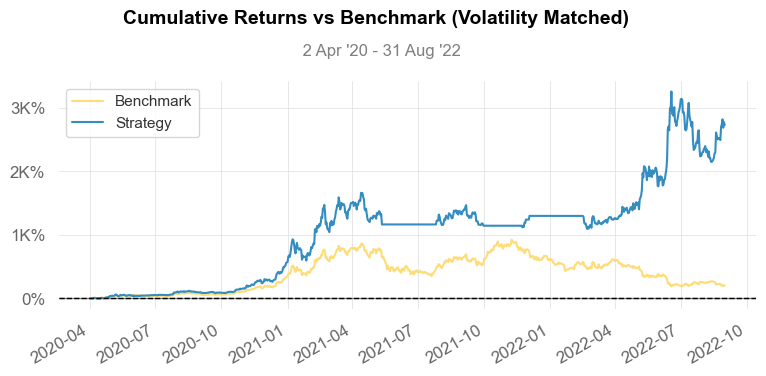

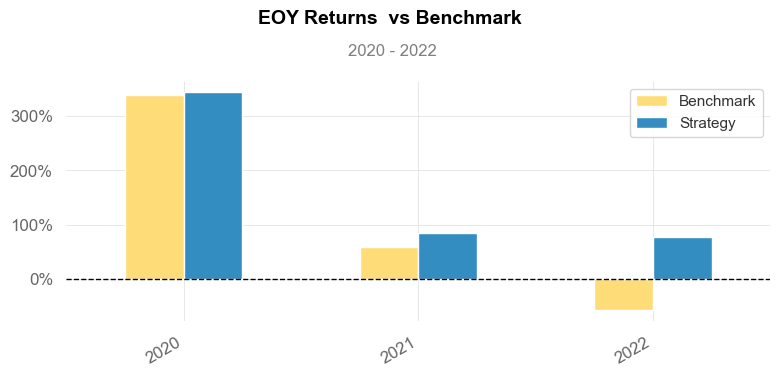

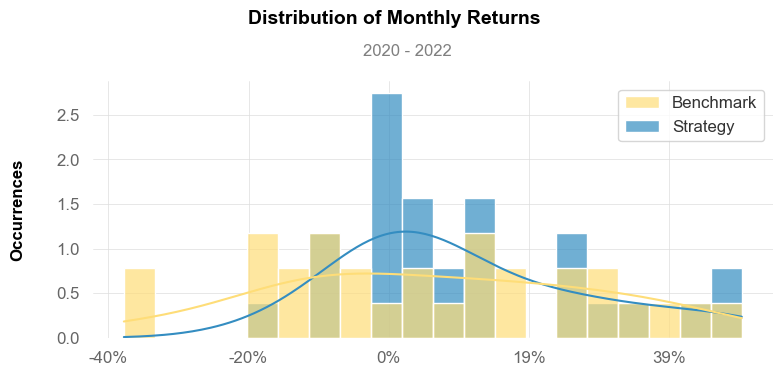

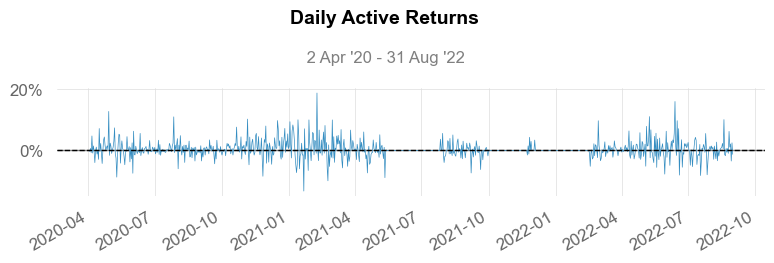

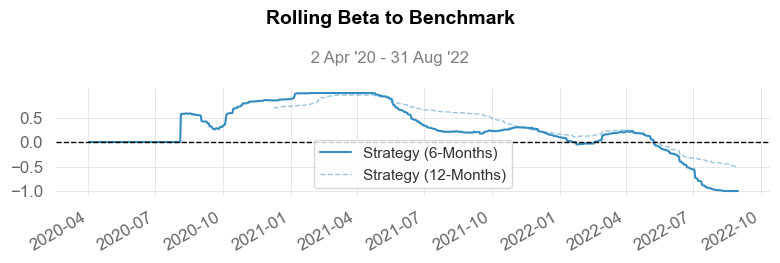

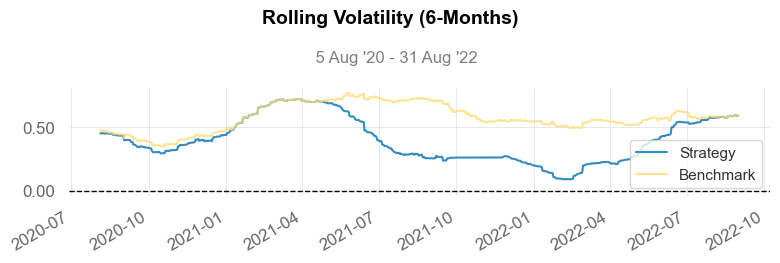

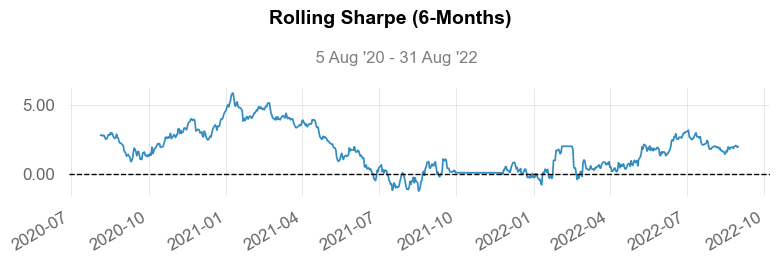

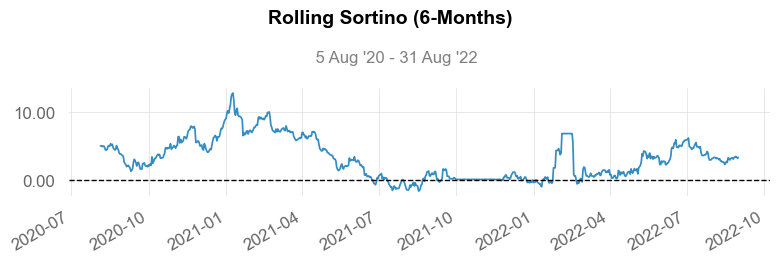

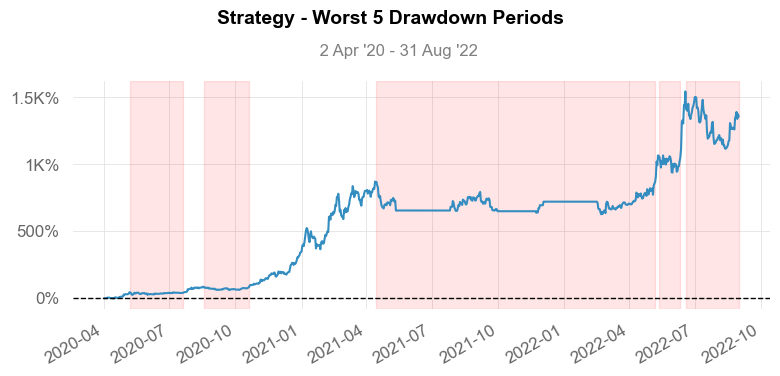

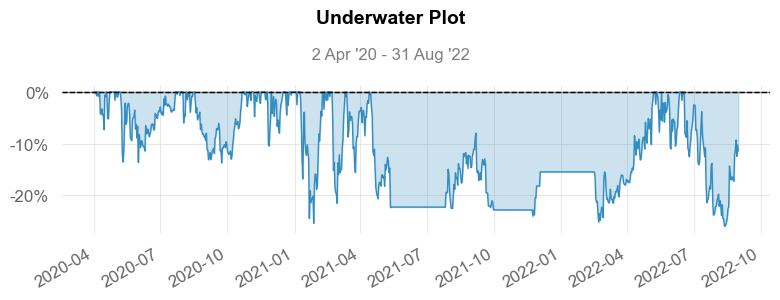

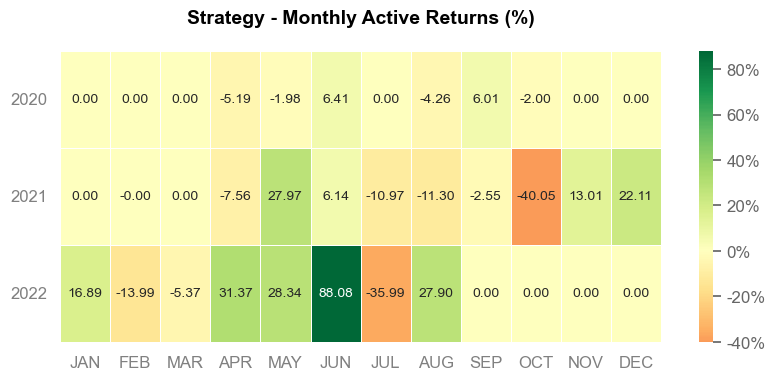

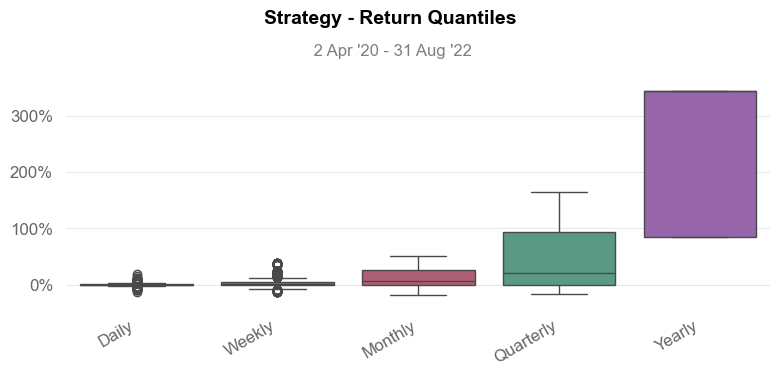

Backtest report for period: 2022-09-01 to 2023-06-30


[*********************100%%**********************]  1 of 1 completed


/Users/lawrencechang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/lawrencechang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/lawrencechang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pa

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-12-08   2022-12-08
End Period                 2023-06-29   2023-06-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       71.0%

Cumulative Return          80.7%        40.58%
CAGR﹪                     108.45%      52.63%

Sharpe                     2.06         1.63
Prob. Sharpe Ratio         97.48%       94.09%
Smart Sharpe               2.05         1.62
Sortino                    3.7          2.92
Smart Sortino              3.68         2.91
Sortino/√2                 2.61         2.07
Smart Sortino/√2           2.6          2.06
Omega                      1.48         1.48

Max Drawdown               -18.7%       -12.1%
Longest DD Days            69           96
Volatility (ann.)          39.2%        28.26%
R^2                        0.53         0.53
Information Ratio          -0.08        -0.08
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-05-29,2023-06-14,2023-06-20,23,-12.102798,-10.522487
2,2023-02-21,2023-03-10,2023-05-27,96,-11.876390,-11.864639
3,2023-01-30,2023-02-10,2023-02-14,16,-8.931321,-8.354993
4,2022-12-15,2022-12-19,2023-01-10,27,-7.723382,-7.118204
5,2023-02-16,2023-02-16,2023-02-16,1,-2.815417,NaN


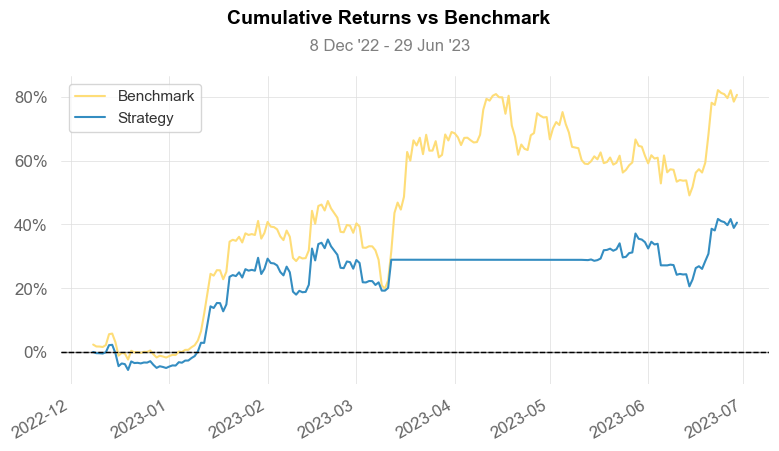

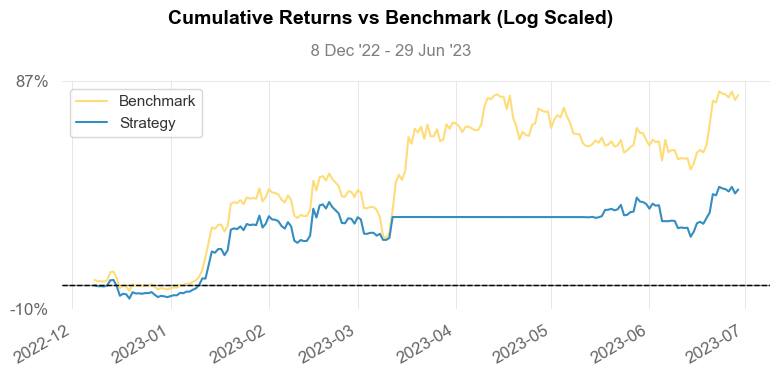

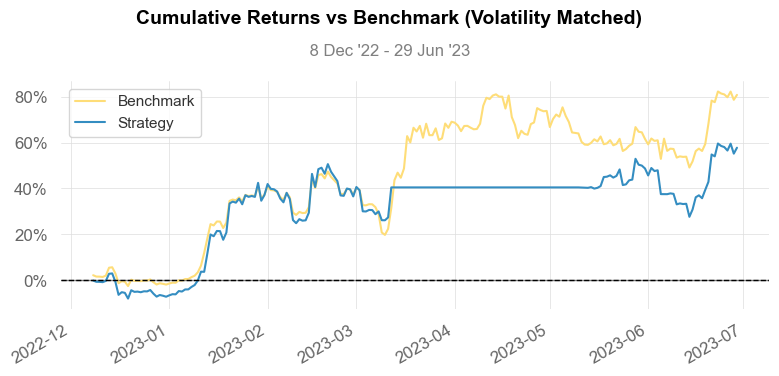

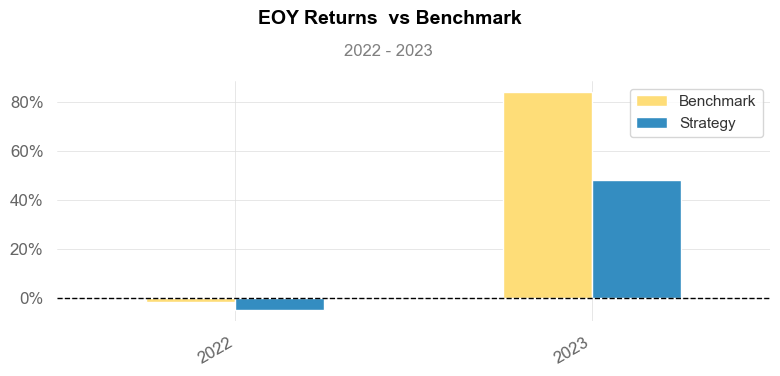

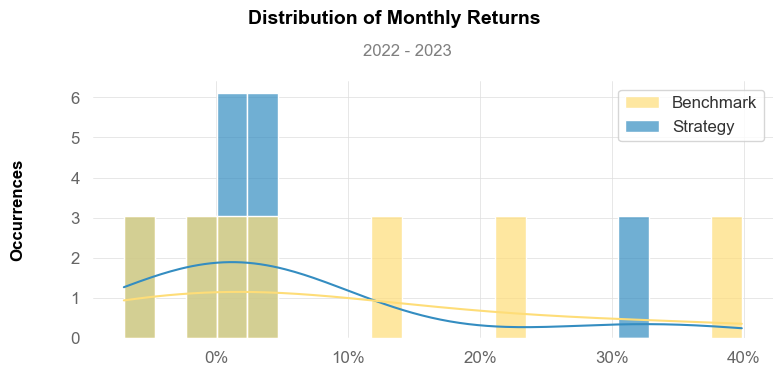

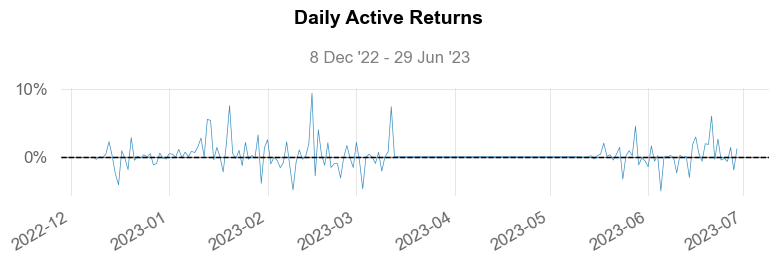

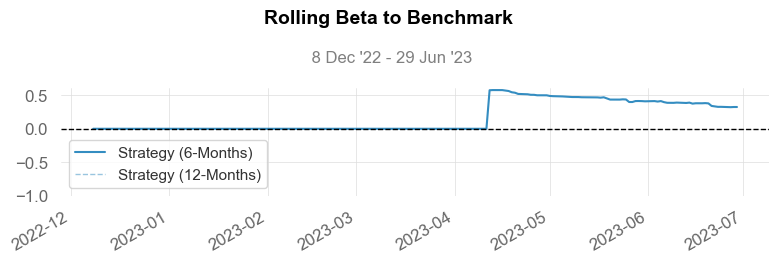

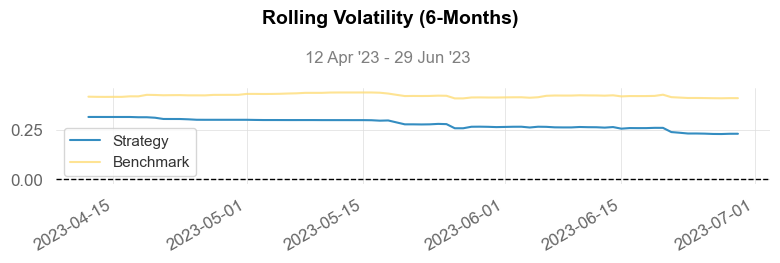

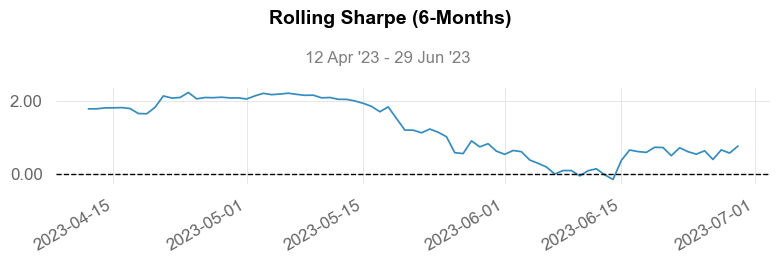

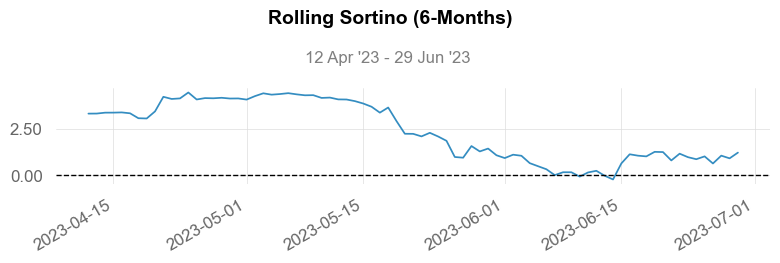

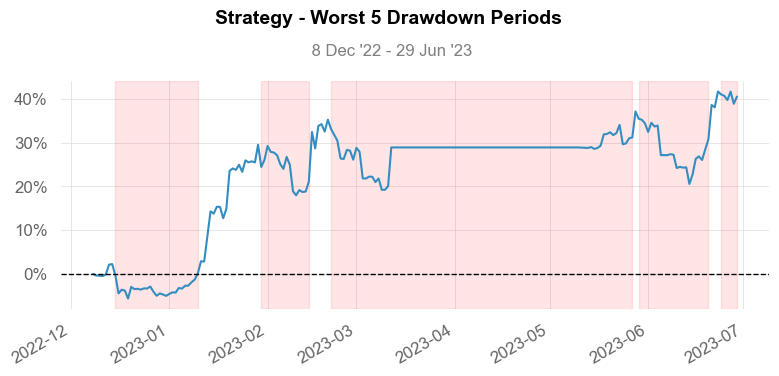

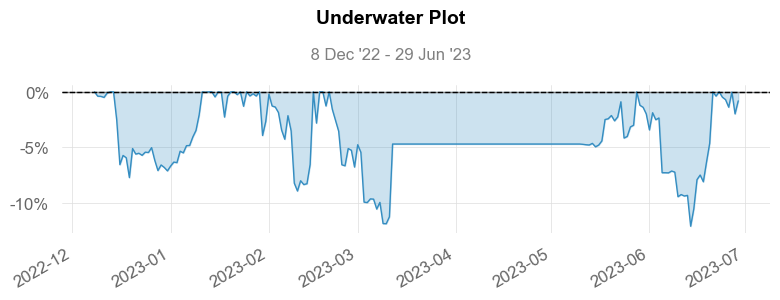

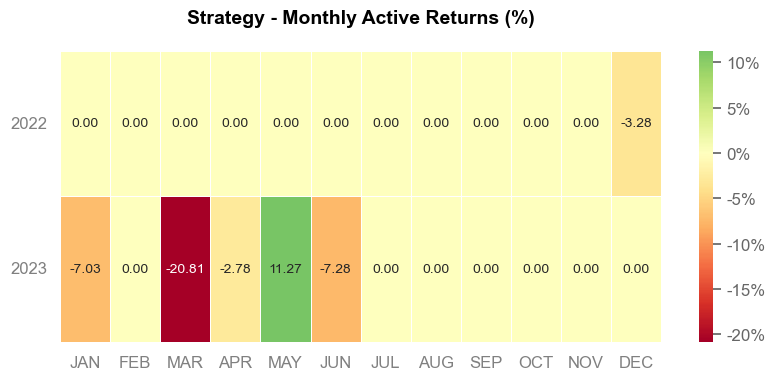

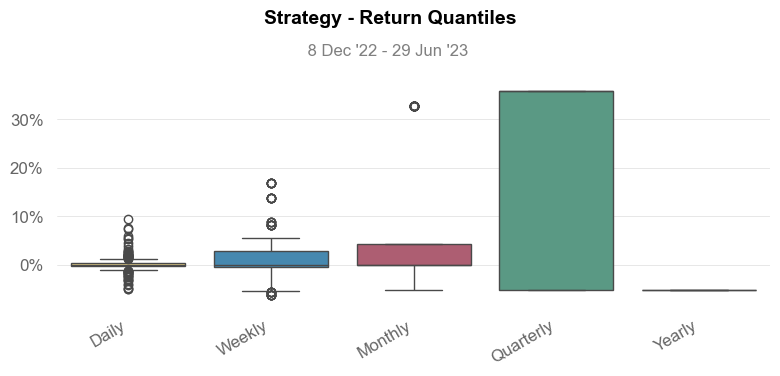

Backtest report for period: 2020-01-01 to 2023-06-30


[*********************100%%**********************]  1 of 1 completed


/Users/lawrencechang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/lawrencechang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/lawrencechang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pa

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-04-02   2020-04-02
End Period                 2023-06-29   2023-06-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       78.0%

Cumulative Return          360.82%      1,504.75%
CAGR﹪                     38.47%       80.62%

Sharpe                     0.87         1.65
Prob. Sharpe Ratio         97.01%       99.99%
Smart Sharpe               0.86         1.63
Sortino                    1.29         2.78
Smart Sortino              1.27         2.74
Sortino/√2                 0.91         1.96
Smart Sortino/√2           0.9          1.94
Omega                      1.44         1.44

Max Drawdown               -76.63%      -33.35%
Longest DD Days            598          389
Volatility (ann.)          54.8%        40.76%
R^2                        0.14         0.14
Information Ratio          0.02         0.02
Calmar           

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-06-19,2022-12-19,2023-06-29,376,-33.354552,-32.602951
2,2021-01-09,2021-01-27,2021-02-07,30,-25.406054,-24.442388
3,2021-04-14,2022-02-21,2022-05-07,389,-25.185746,-23.792475
4,2021-02-22,2021-02-28,2021-03-10,17,-21.554028,-19.728020
5,2021-03-14,2021-03-25,2021-04-12,30,-15.575515,-13.828206


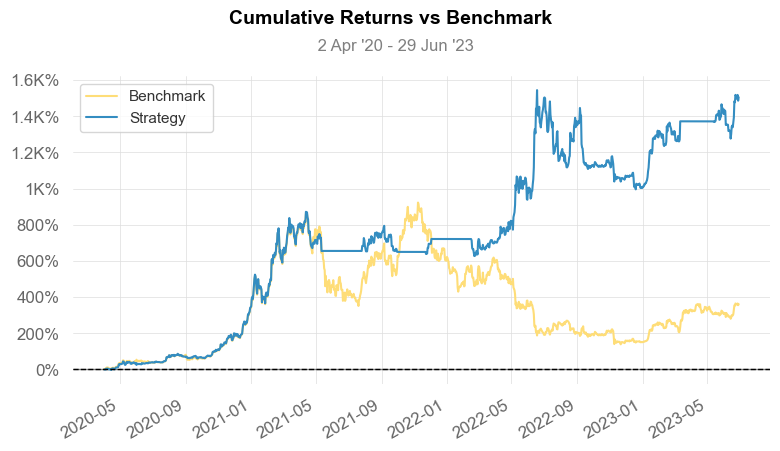

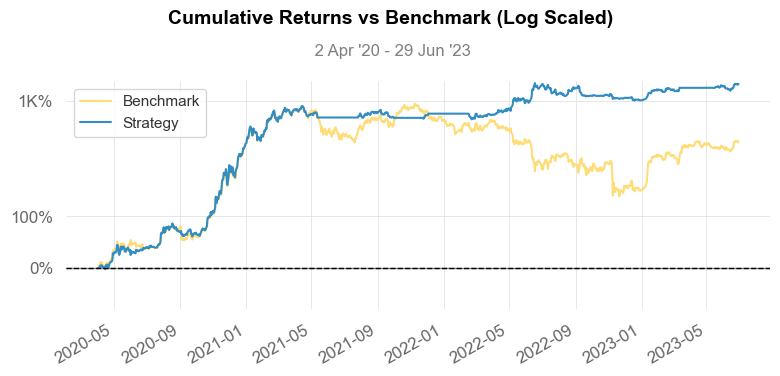

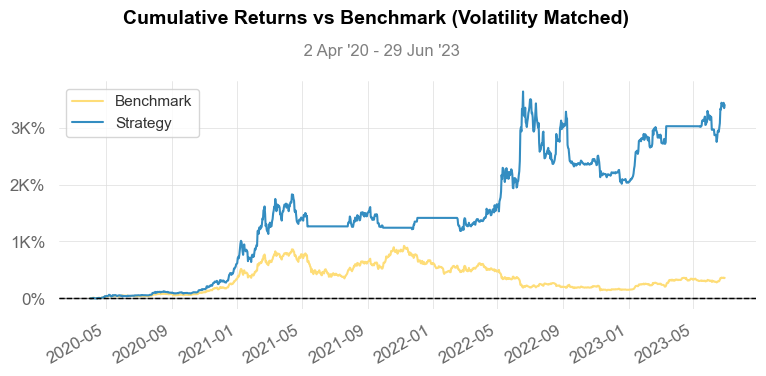

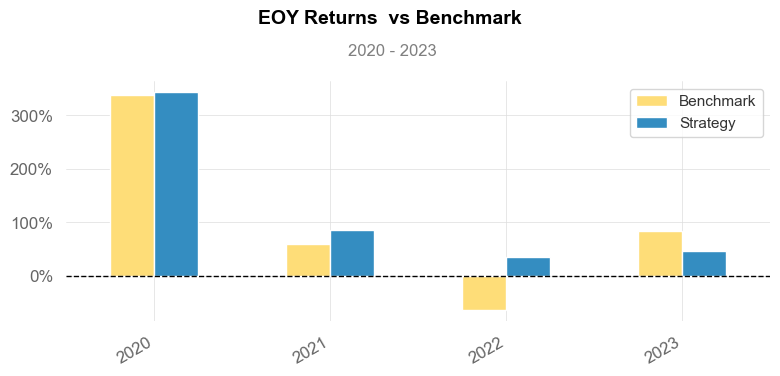

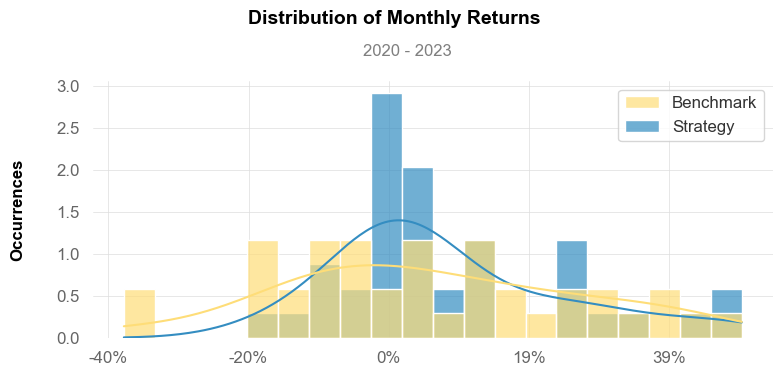

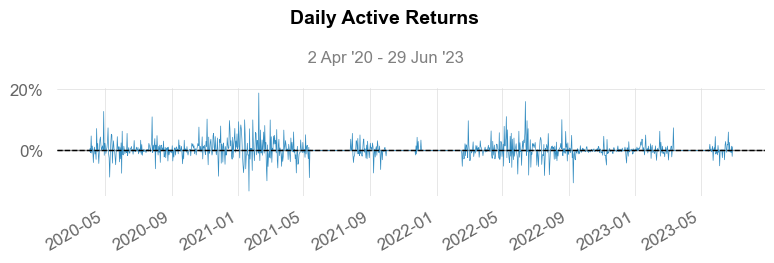

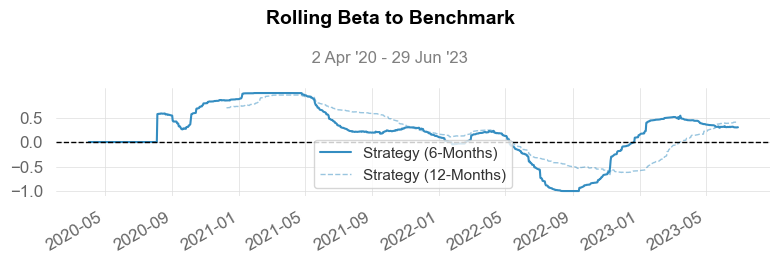

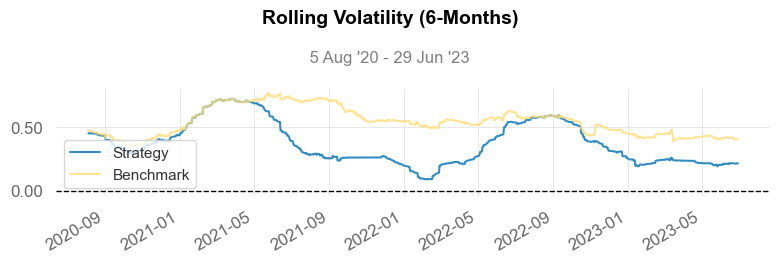

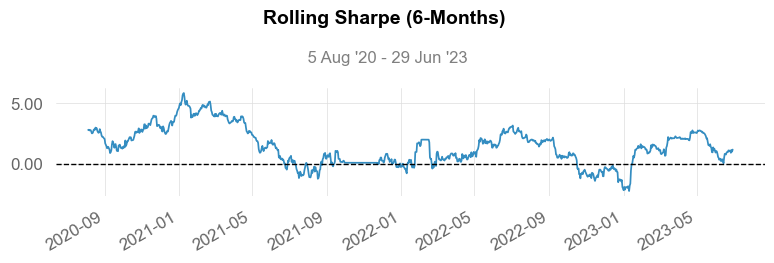

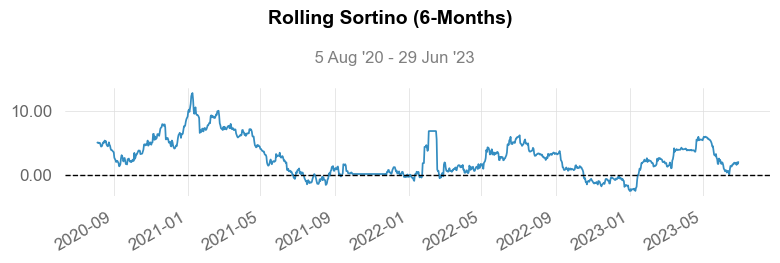

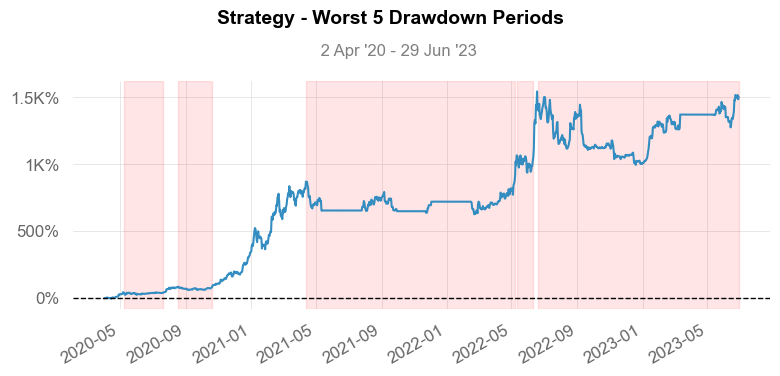

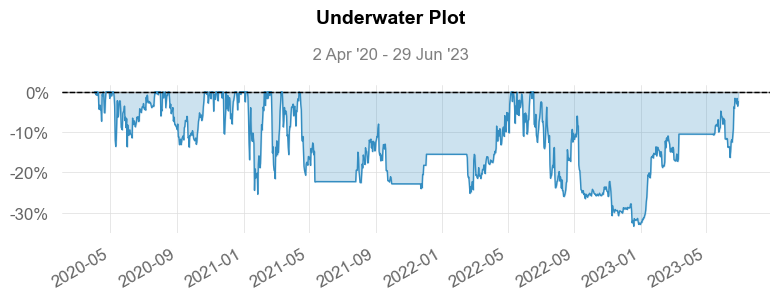

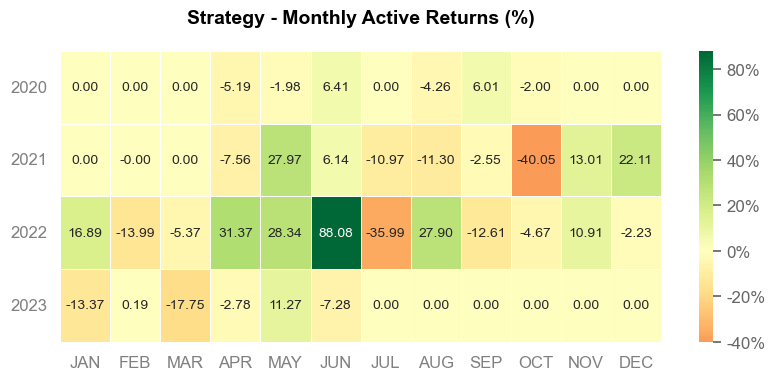

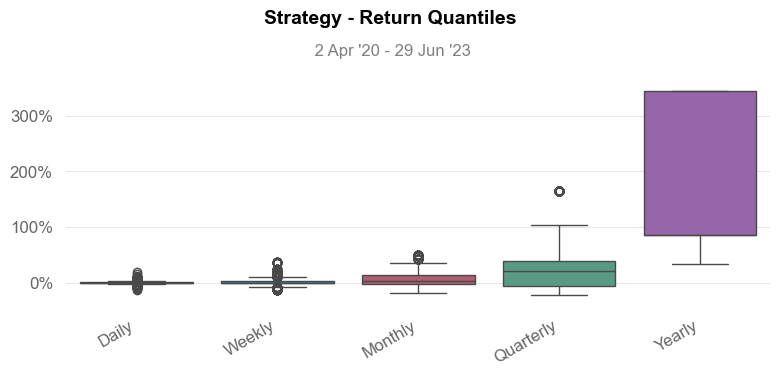

In [20]:
import pandas as pd
import numpy as np
import yfinance as yf
import quantstats as qs

# 下载BTC-USD数据
df = yf.download('BTC-USD', start='2020-01-01', end='2023-06-30')

def mean_reversion_with_fees(df, ema_period, threshold, vwap_period, fee=0.0004):
    if ema_period < 1:
        return -np.inf
    
    df['EMA'] = df['Close'].ewm(span=ema_period).mean()
    df['VWAP'] = (df['Close'] * df['Volume']).rolling(window=vwap_period).sum() / df['Volume'].rolling(window=vwap_period).sum()
    
    df['distance_EMA'] = df['Close'] - df['EMA']
    df['distance_VWAP'] = df['Close'] - df['VWAP']
    
    df['position'] = np.where((df['distance_EMA'] < threshold) & (df['distance_VWAP'] > threshold), -1, np.nan)
    df['position'] = np.where((df['distance_EMA'] > -threshold) & (df['distance_VWAP'] < threshold), 1, df['position'])
    df['position'] = np.where(df['distance_EMA'] * df['distance_EMA'].shift(1) < 0, 0, df['position'])
    df['position'] = df['position'].ffill().fillna(0)
    
    df['strategy_return'] = df['position'].shift(1) * df['Close'].pct_change()
    df['trade'] = df['position'].diff().abs()
    
    df['net_return'] = df['strategy_return'] - df['trade'] * fee
    return df['net_return']

# 定义策略
strategies = [
    (95, 90, 1000),
    (90, 90, 1000),
    (105, 115, 1000)
]

# 定义时间区间
time_periods = [
    ('2020-01-01', '2022-08-31'),
    ('2022-09-01', '2023-06-30'),
    ('2020-01-01', '2023-06-30')
]

# 进行回测并生成报告
for start_date, end_date in time_periods:
    strategy_returns = pd.Series(0, index=df[(df.index >= start_date) & (df.index <= end_date)].index)
    
    for vwap, ema, threshold in strategies:
        sub_df = df[(df.index >= start_date) & (df.index <= end_date)].copy()
        returns = mean_reversion_with_fees(sub_df, ema, threshold, vwap)
        strategy_returns = strategy_returns.add(returns, fill_value=0)
    
    # 等权重策略的平均回报
    strategy_returns /= len(strategies)
    
    # 使用quantstats生成回测报告
    print(f"Backtest report for period: {start_date} to {end_date}")
    qs.reports.full(strategy_returns, "BTC-USD")